In [127]:
import os
import pandas as pd
import math
import numpy as np
import sys
from PIL import Image
import matplotlib.pyplot as plt
from skimage import io,transform
from skimage.feature import blob_dog, blob_log, blob_doh
from skimage.util import invert, crop
from skimage.color import rgb2gray
from skimage.metrics import structural_similarity
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import accuracy_score
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.cluster import KMeans

%matplotlib inline

In [3]:
# So convert each image to 718 x 542 by resizing
cat_ls = ['benign','malignant']
new_subdir = 'resized'
new_size = (718, 542)

# Only need to do once so this if statement is to prevent re-run
run_below = False

if run_below:
    for c in cat_ls:
        dir_fp = os.path.join(base_path, c)
        jpg_ls = [f for f in os.listdir(dir_fp) if '.jpg' in f]
        for j in jpg_ls:
            j_fp = os.path.join(dir_fp, j)
            im = Image.open(j_fp)
            out = im.resize(new_size)
            out_fp = os.path.join(base_path, new_subdir, c, j)
            print(out_fp)
            out.save(out_fp)

In [209]:

def get_rgb_vectors(this_dir_fp):
    imlist = (io.imread_collection(this_dir_fp))
    res = np.zeros(shape=(1,3))
    for i in range(len(imlist)):
        m=transform.resize(imlist[i],(new_size[0],new_size[1],3))
        # re-shape to make list of RGB vectors.
        arr=m.reshape((new_size[0]*new_size[1]),3)
        # consolidate RGB vectors of all images
        res = np.concatenate((res,arr),axis=0)
    res = np.delete(res, (0), axis=0)
    return(res)


In [5]:
benign_dir_p = os.path.join(base_path, new_subdir, cat_ls[0]) + '/ISIC*.jpg'
benign_rgb_v = get_rgb_vectors(benign_dir_p)
print(len(benign_rgb_v))
malignant_dir_p = os.path.join(base_path, new_subdir, cat_ls[1]) + '/ISIC*.jpg'
malignant_rgb_v = get_rgb_vectors(malignant_dir_p)
print(len(malignant_rgb_v))

58373400
58373400


In [6]:
num_benign = len(os.listdir(os.path.join(base_path, new_subdir, cat_ls[0])))
benign_target = [0] * num_benign

num_malignant = len(os.listdir(os.path.join(base_path, new_subdir, cat_ls[1])))
malignant_target = [1] * num_malignant

In [7]:
brv = benign_rgb_v[:,0]
bgv = benign_rgb_v[:,1]
bbv = benign_rgb_v[:,2]

mrv = malignant_rgb_v[:,0]
mgv = malignant_rgb_v[:,1]
mbv = malignant_rgb_v[:,2]


In [8]:
brm = brv.reshape(num_benign,new_size[0]*new_size[1])
bgm = bgv.reshape(num_benign,new_size[0]*new_size[1])
bbm = bbv.reshape(num_benign,new_size[0]*new_size[1])

mrm = mrv.reshape(num_malignant,new_size[0]*new_size[1])
mgm = mgv.reshape(num_malignant,new_size[0]*new_size[1])
mbm = mbv.reshape(num_malignant,new_size[0]*new_size[1])

In [9]:
mrgb_m = np.concatenate((mrm, mgm, mbm), axis=1)
brgb_m = np.concatenate((brm, bgm, bbm), axis=1)

In [10]:
mb_rgb_m = np.concatenate((mrgb_m, brgb_m), axis=0)
len(mb_rgb_m)

300

In [11]:
mb_lbl_m = np.concatenate((malignant_target, benign_target), axis=0)
len(mb_lbl_m)

300

In [12]:
train_mb, test_mb, train_lbl, test_lbl = train_test_split(mb_rgb_m, mb_lbl_m, test_size=0.2, random_state=0)

In [13]:
chnl_size = new_size[0]*new_size[1]
train_mbr = train_mb[:,0:chnl_size]
train_mbg = train_mb[:,chnl_size:2*chnl_size]
train_mbb = train_mb[:,2*chnl_size:3*chnl_size]
test_mbr = test_mb[:,0:chnl_size]
test_mbg = test_mb[:,chnl_size:2*chnl_size]
test_mbb = test_mb[:,2*chnl_size:3*chnl_size]


In [14]:
from sklearn.preprocessing import StandardScaler
scaler_r = StandardScaler()
scaler_r.fit(train_mbr)

scaler_g = StandardScaler()
scaler_g.fit(train_mbg) 

scaler_b = StandardScaler()
scaler_b.fit(train_mbb) 


train_mbrs = scaler_r.transform(train_mbr)
test_mbrs = scaler_r.transform(test_mbr)

train_mbgs = scaler_g.transform(train_mbg)
test_mbgs = scaler_g.transform(test_mbg)

train_mbbs = scaler_b.transform(train_mbb)
test_mbbs = scaler_b.transform(test_mbb)

In [15]:
from sklearn.decomposition import PCA# Make an instance of the Model
pca_r = PCA(.975)
pca_g = PCA(.975)
pca_b = PCA(.975)

In [16]:
pca_r.fit(train_mbrs)
pca_g.fit(train_mbgs)
pca_b.fit(train_mbbs)

PCA(copy=True, iterated_power='auto', n_components=0.975, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

In [17]:
print(pca_r.n_components_)
print(pca_g.n_components_)
print(pca_b.n_components_)

65
95
107


In [18]:
train_mbrt = pca_r.transform(train_mbrs)
train_mbgt = pca_g.transform(train_mbgs)
train_mbbt = pca_b.transform(train_mbbs)

In [19]:
test_mbrt = pca_r.transform(test_mbrs)
test_mbgt = pca_g.transform(test_mbgs)
test_mbbt = pca_b.transform(test_mbbs)

In [20]:
train_mbrgbt = np.concatenate((train_mbrt, train_mbgt, train_mbbt), axis=1)
print(len(train_mbrgbt))
print(len(train_mbrgbt[0]))

240
267


In [21]:
test_mbrgbt = np.concatenate((test_mbrt, test_mbgt, test_mbbt), axis=1)
print(len(test_mbrgbt))
print(len(test_mbrgbt[0]))

60
267


In [22]:
# create all the machine learning models
num_trees = 90
seed      = 3
models = []
models.append(('LDA', LinearDiscriminantAnalysis()))
models.append(('RF', RandomForestClassifier(n_estimators=num_trees, random_state=seed)))
models.append(('SVM', SVC(random_state=seed)))

In [23]:
# 10-fold cross validation
results = []
names = []
for name, model in models:
    curr_kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, train_mbrgbt, train_lbl, cv=curr_kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    message = "%s: mean = %f, std= %f" % (name, cv_results.mean(), cv_results.std())
    print(message)


LDA: mean = 0.566667, std= 0.085797
RF: mean = 0.645833, std= 0.116741
SVM: mean = 0.662500, std= 0.084266


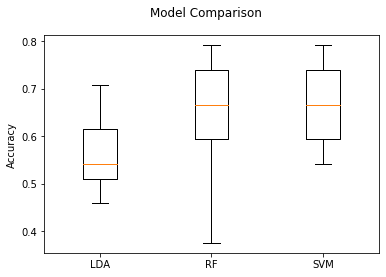

In [24]:
# boxplot model comparison
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel("Accuracy")
plt.show()

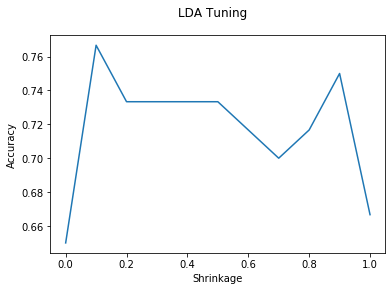

In [424]:
lda_accuracy = []
shrinkage_ls = np.arange(0, 1.1, 0.1)
shrinkage_ls

for s in shrinkage_ls:
    my_lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage=s)
    my_lda.fit(train_mbrgbt, train_lbl)
    my_lda_predict = my_lda.predict(test_mbrgbt)
    my_lda_accuracy = accuracy_score(test_lbl, my_lda_predict, normalize=True)
    lda_accuracy.append(my_lda_accuracy)

fig = plt.figure()
fig.suptitle('LDA Tuning')
ax = fig.add_subplot(111)
plt.plot(shrinkage_ls, lda_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Shrinkage")
plt.show()


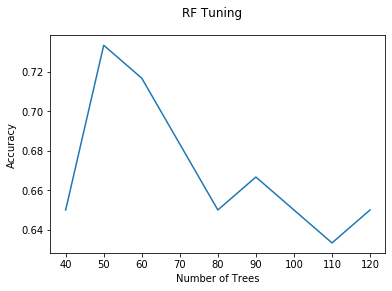

In [26]:
rf_accuracy = []
ntrees_ls = np.arange(40, 130, 10)
ntrees_ls

for nt in ntrees_ls:
    my_rf = RandomForestClassifier(n_estimators=nt, random_state=seed)
    my_rf.fit(train_mbrgbt, train_lbl)
    my_rf_predict = my_rf.predict(test_mbrgbt)
    my_rf_accuracy = accuracy_score(test_lbl, my_rf_predict, normalize=True)
    rf_accuracy.append(my_rf_accuracy)

fig = plt.figure()
fig.suptitle('RF Tuning')
ax = fig.add_subplot(111)
plt.plot(ntrees_ls, rf_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Number of Trees")
plt.show()

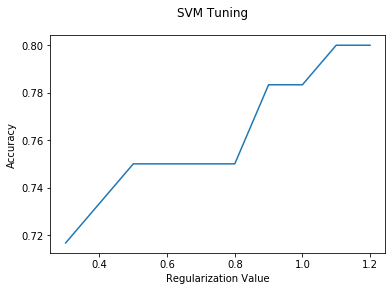

In [27]:
#kernel_ls = ['linear', 'poly', 'rbf', 'sigmoid']
reg_ls = np.arange(0.3, 1.3, 0.1)
svm_accuracy = []

for reg in reg_ls:
    my_svm = SVC(C=reg)
    my_svm.fit(train_mbrgbt, train_lbl)
    my_svm_predict = my_svm.predict(test_mbrgbt)
    my_svm_accuracy = accuracy_score(test_lbl, my_svm_predict, normalize=True)
    svm_accuracy.append(my_svm_accuracy)


fig = plt.figure()
fig.suptitle('SVM Tuning')
ax = fig.add_subplot(111)
plt.plot(reg_ls, svm_accuracy)
plt.ylabel("Accuracy")
plt.xlabel("Regularization Value")
plt.show()

In [28]:
def distance(p0, p1):
    return(math.sqrt((p0[0] - p1[0])**2 + (p0[1] - p1[1])**2))

In [333]:
def get_best_center(blob_set, img_size):
    img_center_loc = (img_size[0]/2, img_size[1]/2)
    best_dist = distance(img_size, img_center_loc)
    best_center = img_size
    for b in blob_set:
        y, x, r = b
        blob_center_loc = (x, y)
        blob_center_dist = distance(blob_center_loc, img_center_loc)
        if blob_center_dist < best_dist:
            best_dist = blob_center_dist
            best_center = blob_center_loc
    max_dist = distance(img_size, img_center_loc) / 4
    if (best_dist >= max_dist):
        best_center = img_center_loc
    if (best_center[0] == 0):
        best_center = img_center_loc
    if (best_center[1] == 0):
        best_center = img_center_loc
    return(best_center)


In [334]:
def best_center_crop(img_to_crop, new_center, img_size):
    #print(img_size)
    #print(new_center)
    w1 = new_center[0] - 0
    w2 = img_size[0]-new_center[0]
    #print(w1, w2)
    best_w = min(w1, w2)
    #print(best_w)
    h1 = new_center[1] - 0
    h2 = img_size[1]-new_center[0]
    #print(h1, h2)
    best_h = min(h1, h2)
    #print(best_h)
    w_start = np.int(new_center[0] - best_w)
    w_nd = np.int(new_center[0] + best_w)
    h_start = np.int(new_center[1] - best_h)
    h_nd = np.int(new_center[1] + best_h)
    #print(w_start,w_nd,h_start,h_nd)
    return(img_to_crop[h_start:h_nd,w_start:w_nd])

    
t = best_center_crop(imlist[0], (353.0, 269.0), new_size)
print(t.shape)

(378, 706, 3)


In [369]:
def cut_image(img_to_cut, direction):
    height = img_to_cut.shape[0]
    width = img_to_cut.shape[1]
    #print(height, width)
    if (direction=='vertical'):
        h_nd = np.int(height / 2.0)
        top_img = img_to_cut[0:h_nd,:]
        bottom_img = img_to_cut[h_nd:,:]
        flip_bottom_img = bottom_img[::-1,:]
        top_height = top_img.shape[0]
        #ntop_img = transform.resize(top_img,(top_height,width,3))
        #nflip_bottom_img=transform.resize(flip_bottom_img,(top_height,width,3))
        nflip_bottom_img = flip_bottom_img[0:h_nd,:]
        return([top_img, nflip_bottom_img])
    elif (direction=='horizontal'):
        w_nd = np.int(width / 2.0)
        left_img = img_to_cut[:,0:w_nd]
        right_img = img_to_cut[:,w_nd:]
        flip_right_img = right_img[:,::-1]
        left_width = left_img.shape[1]
        #nleft_img =transform.resize(left_img,(height,left_width,3))
        #nflip_right_img =transform.resize(flip_right_img,(height,left_width,3))
        nflip_right_img = flip_right_img[:,0:w_nd]
        return([left_img,nflip_right_img])

In [377]:
def get_channel_variations(c_vec):
    c_vec_r = c_vec.reshape(-1,1)
    v_mean = np.mean(c_vec_r)
    v_std = np.std(c_vec_r)
    km_results = KMeans(n_clusters = 2, random_state=0).fit(c_vec_r)
    big_label = np.argmax(km_results.cluster_centers_)
    big_idx = np.where(km_results.labels_ == big_label)[0]
    small_idx = np.where(km_results.labels_ != big_label)[0]
    big_clstr_mean = np.mean(c_vec_r[big_idx])
    big_clstr_std = np.std(c_vec_r[big_idx])
    small_clstr_mean = np.mean(c_vec_r[small_idx])
    small_clstr_std = np.std(c_vec_r[small_idx])
    return([v_mean, v_std, big_clstr_mean, big_clstr_std, small_clstr_mean, small_clstr_std])

In [403]:
def get_np_features(this_dir_fp):
    imlist = (io.imread_collection(this_dir_fp))
    print(len(imlist))
    res = np.zeros(26)
    for i in range(len(imlist)):
        print(i)
        this_img = imlist[i]
        inv_img = invert(this_img, signed_float=False)
        image_gray = rgb2gray(inv_img)
        blobs_dog = blob_dog(image_gray, max_sigma=350, min_sigma=50, threshold=.2)
        img_best_center = get_best_center(blobs_dog, new_size)
        #print(img_best_center)
        cropped_img = best_center_crop(this_img, img_best_center, new_size)
        cropped_img_vert = cut_image(cropped_img, "vertical")
        cropped_img_hor = cut_image(cropped_img, "horizontal")
        vert_sym =  structural_similarity(cropped_img_vert[0], cropped_img_vert[1], multichannel=True)
        hor_sym =  structural_similarity(cropped_img_hor[0], cropped_img_hor[1], multichannel=True)
        rchv = cropped_img[:,:,0][0]
        r_vars = get_channel_variations(rchv)
        gchv = cropped_img[:,:,1][0]
        g_vars = get_channel_variations(gchv)
        bchv = cropped_img[:,:,2][0]
        b_vars = get_channel_variations(bchv)
        grchv = 0.2125 * rchv  + 0.7154 * gchv + 0.0721 * bchv
        gr_vars = get_channel_variations(grchv)
        out_vars = np.concatenate(([vert_sym, hor_sym], r_vars), axis=None)
        out_vars = np.concatenate((out_vars, g_vars), axis=None)
        out_vars = np.concatenate((out_vars, b_vars), axis=None)
        out_vars = np.concatenate((out_vars, gr_vars), axis=None)
        res = np.concatenate((res,out_vars),axis=0)
        if (i % 25 == 0):
            print(out_vars)
    #res = np.delete(res, (0), axis=0)
    return(res)

In [404]:
benign_dir_p = os.path.join(base_path, new_subdir, cat_ls[0]) + '/ISIC*.jpg'
benign_np_features = get_np_features(benign_dir_p)
print(len(benign_np_features))


150
0
[  0.69230389   0.67037744 152.75558659  25.97985435 165.19607843
  10.43667189 107.72903226  11.66484085 175.29329609  46.28733444
 201.46730769  16.02434711 105.85204082  22.49112174 202.60893855
  62.05982992 240.448       17.97763321 115.01851852  32.12777772
 172.47349064  43.02918265 196.69224395  14.75038864 107.76594974
  21.51399905]
1
2


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


3


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


4


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


5


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


6


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encounter

7
8


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_

9


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_

10
11
12


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


13
14


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


15


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


16
17
18
19
20
21
22
23
24
25
[  0.61911092   0.62070563 238.52689873   5.04999416 241.55979644
   2.61763679 233.53974895   4.02158006 186.53639241   9.58367241
 192.00704225   5.47786388 175.22330097   5.4637944  229.06487342
  14.33098463 239.14136126   6.10389252 213.668        8.36981338
 200.65067848   8.72656115 205.74427238   4.7631713  190.55959623
   5.37069977]
26
27
28
29
30
31


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


32
33


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


34


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


35
36
37
38
39
40
41
42
43


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


44


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_

45
46
47
48


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


49
50
[  0.65441373   0.64823398 204.82869081   8.30074744 211.96438356
   4.05392993 197.45042493   4.00827135 181.83286908   9.14932942
 188.4939759    4.62672565 172.70957096   5.00377489 210.18802228
  10.3029066  217.57756563   5.25216835 199.83277592   5.70033115
 188.76388774   8.91813524 195.6072245    4.33454948 180.15591698
   4.78929091]
51
52
53


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


54


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


55


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


56


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


57


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encounter

58
59
60
61
62
63
64
65
66
67
68


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


69
70
71
72


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encounter

73


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


74
75
[  0.65745631   0.65058701 171.45264624   8.8725022  176.59090909
   4.45616854 160.82478632   5.73705017 159.67409471   9.15555284
 164.81854839   4.60138245 148.18018018   5.70632366 171.7270195
  10.45433736 178.05416667   4.84264728 158.96638655   6.23278506
 163.04605279   9.14823622 168.14993695   4.60305261 151.492715
   5.72064807]
76
77
78
79
80
81
82


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

83


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


84


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


85
86
87
88


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


89


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


90
91


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


92


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


93
94
95
96
97
98
99
100
[  0.70703364   0.70612725 182.96902655  21.70791455 191.00343053
   8.04042031 133.66315789  11.79706522 152.85545723  35.61511385
 166.40587219  13.08505588  73.60606061  18.19802308 154.64896755
  46.33971732 172.07758621  18.31522396  51.5         20.82152046
 159.3839028   33.38216026 171.93720671  12.42816875  84.19349485
  16.32307054]
101
102
103
104
105


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


106
107
108


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


109
110
111


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

112
113
114


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


115


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


116
117
118
119


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_

120


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

121


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


122
123
124
125


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


[  0.67817108   0.73858832 186.57381616  12.77562899 194.55844156
   5.78696888 172.1640625    8.63927925 156.09610028  16.76124198
 171.8136646    7.7389111  143.31565657   9.82158298 183.87325905
  13.39788921 195.14244186   6.28028022 173.50802139   9.16974156
 164.57534805  15.27077391 178.49258313   7.19824178 153.00132092
   9.43414253]
126
127
128
129


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


130


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


131
132
133
134


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


135


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


136
137
138
139
140
141
142
143


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


144
145


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


146
147
148


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


149
3926


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


In [406]:
malignant_dir_p = os.path.join(base_path, new_subdir, cat_ls[1]) + '/ISIC*.jpg'
malignant_np_features = get_np_features(malignant_dir_p)
print(len(malignant_np_features))

150
0


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


[  0.64136652   0.64683848 164.85236769  12.13138101 165.29748603
   8.74336424   5.5          1.5        155.3189415   15.40203846
 159.9468599    6.87632246 125.69072165  20.93503    157.045961
  21.45226882 162.76226994   9.94834449 100.57575758  22.73834074
 157.46931267  14.75882146 162.30557197   6.10488559 132.11049217
  19.97092614]
1


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


2


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


3
4
5


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


6
7


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


8


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_

9


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


10


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


11
12


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


13


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


14


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

15


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


16
17


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


18


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_

19
20
21
22
23


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

24
25
[  0.76825231   0.76505088 181.05538462   9.05538566 185.69593148
   4.23274233 169.21311475   7.09524913 165.00923077  11.83982488
 169.99414062   5.92020217 146.51449275   9.79739355 150.35692308
  12.1902353  156.38607595   6.04420218 134.11931818   9.42690007
 167.36260708  11.09650982 171.59537932   5.88813395 148.27926102
   8.77573339]
26
27


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_

28


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


29
30
31
32
33
34
35
36
37


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

38
39
40


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

41
42


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_

43
44


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


45
46
47


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


48
49
50
[  0.63033459   0.62261934 239.76239067   6.87882093 242.7839851
   3.71241369 228.87248322   4.0851484  160.85568513   6.15740006
 166.38486842   3.46408756 156.45549738   3.85290516 130.21282799
   7.22190213 135.37301587   4.74157698 123.87987013   3.97335084
 175.41401006   5.94264988 180.28105284   3.32659757 170.76882678
   3.77790025]
51
52
53
54
55
56


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

57


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

58


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


59
60
61


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


62
63
64
65


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


66
67
68


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


69


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


70
71
72
73


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


74


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


75
[  0.48064212   0.48146266 144.49442897  57.74843964 204.22865854
  16.91476576  94.25641026  19.34400848  87.16016713  58.57212991
 149.03134796  22.84208337  37.69423559  15.7793921   96.07938719
  52.0041309  154.0704698   19.58902584  54.93333333  16.48997772
  99.98677354  57.69996089 160.99004375  21.22609266  50.93891809
  15.68685382]
76


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


77


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


78
79
80


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


81


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

82
83
84
85
86
87


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


88


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


89
90
91


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


92
93
94


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

95


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


96
97


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


98
99


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


100
[  0.51928532   0.51480792 168.66066066   7.68264193 173.71867008
   4.26100312 161.46909091   5.38836702 137.83783784  11.07444685
 144.65411765   5.57476569 125.81742739   7.59557821 136.42342342
  16.80736087 147.55050505   8.97274069 120.1037037   11.43663644
 144.28570841  10.60046963 150.81694397   5.3918553  132.91652058
   7.33870876]
101
102
103
104


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


105


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


106
107
108
109
110
111
112
113
114
115


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


116
117
118


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


119


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


120
121


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_

122
123


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


124
125
[  0.72852826   0.73162218 194.8768997   12.70013216 204.72357724
   5.09152143 182.30449827   7.23008042 152.96504559  35.06386262
 183.49279539  14.28050928 118.90353698  13.18031101 161.6337386
  37.36456254 193.57142857  13.60439752 123.75415282  13.7040149
 162.49632736  30.31494679 187.84346194  12.97260223 131.87562785
  10.58852419]
126


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


127
128
129


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


130
131


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


132
133
134
135
136


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


137
138
139


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


140
141


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:129: RuntimeWarning: invalid value encountered in subtract
  d = np.sqrt(np.sum((pos2 - pos1)**2))


142
143
144


/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:125: RuntimeWarning: invalid value encountered in double_scalars
  r1 = blob1[-1] / blob2[-1]
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: divide by zero encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:126: RuntimeWarning: invalid value encountered in true_divide
  pos1 = blob1[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: divide by zero encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)
/home/alex/.local/lib/python3.6/site-packages/skimage/feature/blob.py:127: RuntimeWarning: invalid value encountered in true_divide
  pos2 = blob2[:ndim] / (max_sigma * root_ndim)


145
146
147
148
149
3926


In [407]:
b_npf = benign_np_features.reshape(151,26)[1:151,:]
m_npf = malignant_np_features.reshape(151,26)[1:151,:]
mb_npf = np.concatenate((m_npf, b_npf), axis=0)
mb_npf.shape

(300, 26)

In [408]:
train_mbnp, test_mbnp, train_lbl, test_lbl = train_test_split(mb_npf, mb_lbl_m, test_size=0.2, random_state=0)

In [409]:
scaler_np = StandardScaler() # Fit on training set only.
scaler_np.fit(train_mbnp)    # Apply transform to both the training set and the test set.

train_mbnps = scaler_np.transform(train_mbnp)
test_mbnps = scaler_np.transform(test_mbnp)

In [410]:
# 10-fold cross validation
results = []
names = []
for name, model in models:
    curr_kfold = KFold(n_splits=10)
    cv_results = cross_val_score(model, train_mbnps, train_lbl, cv=curr_kfold, scoring="accuracy")
    results.append(cv_results)
    names.append(name)
    message = "%s: mean = %f, std= %f" % (name, cv_results.mean(), cv_results.std())
    print(message)

LDA: mean = 0.670833, std= 0.112500
RF: mean = 0.695833, std= 0.059073
SVM: mean = 0.695833, std= 0.087500


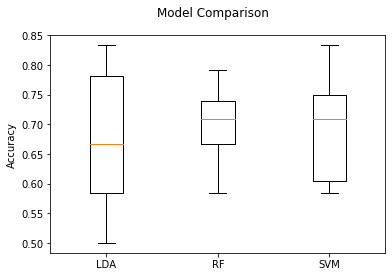

In [411]:
# boxplot model comparison
fig = plt.figure()
fig.suptitle('Model Comparison')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.ylabel("Accuracy")
plt.show()

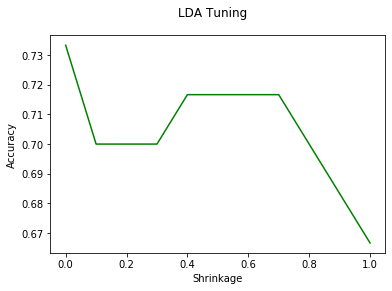

In [415]:

lda_accuracy = []
shrinkage_ls = np.arange(0, 1.1, 0.1)
shrinkage_ls

for s in shrinkage_ls:
    my_lda = LinearDiscriminantAnalysis(solver='lsqr',shrinkage=s)
    my_lda.fit(train_mbnps, train_lbl)
    my_lda_predict = my_lda.predict(test_mbnps)
    my_lda_accuracy = accuracy_score(test_lbl, my_lda_predict, normalize=True)
    lda_accuracy.append(my_lda_accuracy)

fig = plt.figure()
fig.suptitle('LDA Tuning')
ax = fig.add_subplot(111)
plt.plot(shrinkage_ls, lda_accuracy, color='green')
plt.ylabel("Accuracy")
plt.xlabel("Shrinkage")
plt.show()

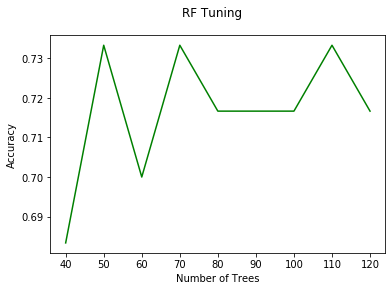

In [413]:
rf_accuracy = []
ntrees_ls = np.arange(40, 130, 10)
ntrees_ls

for nt in ntrees_ls:
    my_rf = RandomForestClassifier(n_estimators=nt, random_state=seed)
    my_rf.fit(train_mbnps, train_lbl)
    my_rf_predict = my_rf.predict(test_mbnps)
    my_rf_accuracy = accuracy_score(test_lbl, my_rf_predict, normalize=True)
    rf_accuracy.append(my_rf_accuracy)

fig = plt.figure()
fig.suptitle('RF Tuning')
ax = fig.add_subplot(111)
plt.plot(ntrees_ls, rf_accuracy, color="green")
plt.ylabel("Accuracy")
plt.xlabel("Number of Trees")
plt.show()

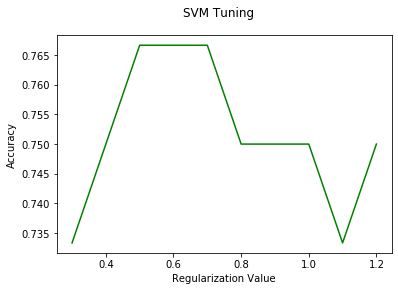

In [414]:
#kernel_ls = ['linear', 'poly', 'rbf', 'sigmoid']
reg_ls = np.arange(0.3, 1.3, 0.1)
svm_accuracy = []

for reg in reg_ls:
    my_svm = SVC(C=reg)
    my_svm.fit(train_mbnps, train_lbl)
    my_svm_predict = my_svm.predict(test_mbnps)
    my_svm_accuracy = accuracy_score(test_lbl, my_svm_predict, normalize=True)
    svm_accuracy.append(my_svm_accuracy)


fig = plt.figure()
fig.suptitle('SVM Tuning')
ax = fig.add_subplot(111)
plt.plot(reg_ls, svm_accuracy, color="green")
plt.ylabel("Accuracy")
plt.xlabel("Regularization Value")
plt.show()